In [10]:
import pandas as pd
import numpy as np

In [11]:
#load dataset
df = pd.read_csv("data/goodreads_data.csv")
df.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"['Classics', 'Fiction', 'Historical Fiction', ...",4.27,"5,691,311",https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"['Fantasy', 'Fiction', 'Young Adult', 'Magic',...",4.47,"9,278,135",https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","['Classics', 'Fiction', 'Romance', 'Historical...",4.28,"3,944,155",https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"['Classics', 'Nonfiction', 'History', 'Biograp...",4.18,"3,488,438",https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"['Classics', 'Fiction', 'Dystopia', 'Fantasy',...",3.98,"3,575,172",https://www.goodreads.com/book/show/170448.Ani...


In [12]:
df.isnull().sum()

Unnamed: 0      0
Book            0
Author          0
Description    77
Genres          0
Avg_Rating      0
Num_Ratings     0
URL             0
dtype: int64

In [13]:
df["Description"] = df["Description"].fillna("")

In [14]:
#to check again
#data.isnull().sum()

In [15]:
#clean numerical columns
df['Num_Ratings'] = df['Num_Ratings'].str.replace(',', '').astype(float)
df['Avg_Rating'] = df['Avg_Rating'].astype(float)

In [16]:
import re

def clean_genres(genre_text):
    if pd.isna(genre_text):
        return []

    # Remove brackets
    genre_text = re.sub(r"[\[\]]", "", str(genre_text))

    # Split by comma
    genres = genre_text.split(",")

    # Clean each genre
    cleaned = set()
    for g in genres:
        g = g.strip()
        g = g.replace("'", "").replace('"', "")
        if g:
            cleaned.add(g)

    return list(cleaned)

In [17]:
df["Genres"] = df["Genres"].apply(clean_genres)
df.head()

,Unnamed: 0,Book,Author,Description,Genres,Avg_Rating,Num_Ratings,URL
0,0,To Kill a Mockingbird,Harper Lee,The unforgettable novel of a childhood in a sl...,"[School, Literature, Historical Fiction, Histo...",4.27,5691311.0,https://www.goodreads.com/book/show/2657.To_Ki...
1,1,Harry Potter and the Philosopher’s Stone (Harr...,J.K. Rowling,Harry Potter thinks he is an ordinary boy - un...,"[Fiction, Fantasy, Classics, Young Adult, Chil...",4.47,9278135.0,https://www.goodreads.com/book/show/72193.Harr...
2,2,Pride and Prejudice,Jane Austen,"Since its immediate success in 1813, Pride and...","[Literature, Historical Fiction, Historical, F...",4.28,3944155.0,https://www.goodreads.com/book/show/1885.Pride...
3,3,The Diary of a Young Girl,Anne Frank,Discovered in the attic in which she spent the...,"[Historical, Classics, Memoir, Biography, Nonf...",4.18,3488438.0,https://www.goodreads.com/book/show/48855.The_...
4,4,Animal Farm,George Orwell,Librarian's note: There is an Alternate Cover ...,"[School, Literature, Fiction, Fantasy, Politic...",3.98,3575172.0,https://www.goodreads.com/book/show/170448.Ani...


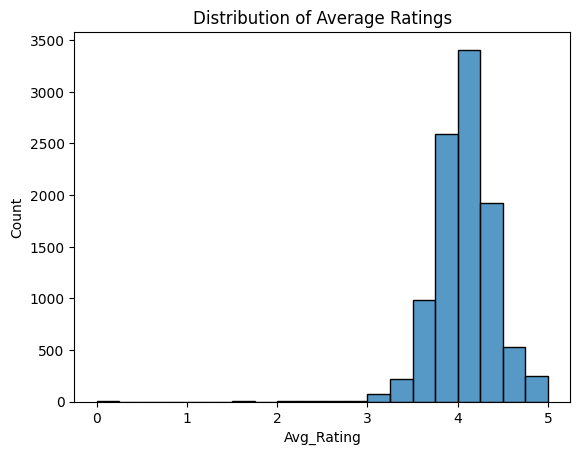

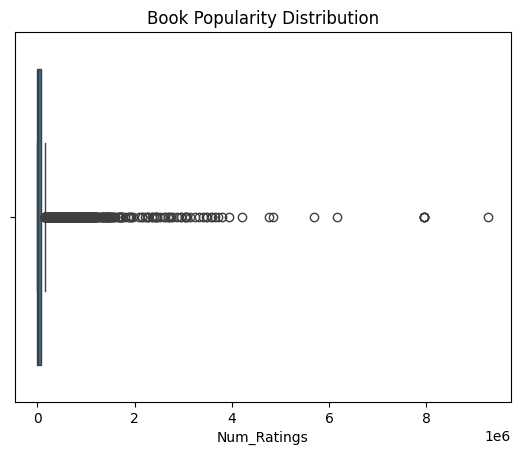

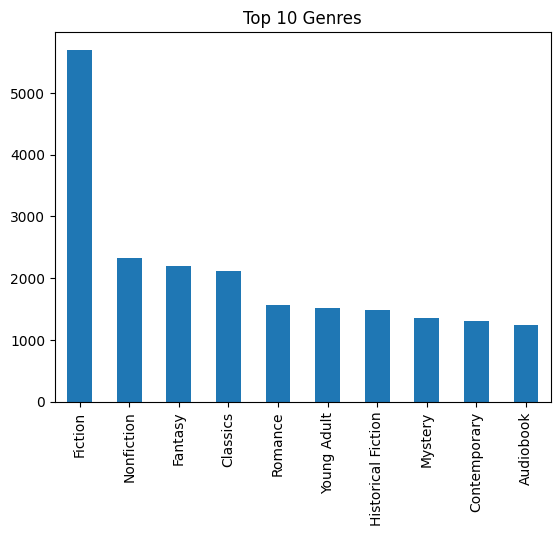

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rating distribution
sns.histplot(df["Avg_Rating"], bins=20)
plt.title("Distribution of Average Ratings")
plt.show()

# Popularity
sns.boxplot(x=df["Num_Ratings"])
plt.title("Book Popularity Distribution")
plt.show()

# Genre frequency
from collections import Counter
genre_counts = Counter([g for sub in df["Genres"] for g in sub])
pd.Series(genre_counts).sort_values(ascending=False).head(10).plot(kind="bar")
plt.title("Top 10 Genres")
plt.show()

In [19]:
#encode genres
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(df["Genres"])
print("Genres encoded.")

Genres encoded.


In [20]:
#encode description (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(df['Description'])

In [21]:
#encode description (SVD)
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=100, random_state=42)
desc_features = svd.fit_transform(tfidf_matrix)

In [22]:
#Feature matrix
features = np.hstack([
    genre_matrix,
    desc_features,
    df[['Avg_Rating', 'Num_Ratings']].values
])

In [23]:
#target variable
df['Score'] = df['Avg_Rating'] + (np.log(df['Num_Ratings']+1) / 10)
y = df['Score']

In [24]:
X = features

In [25]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test ,y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42)

In [26]:
#Linear Regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

print("Fitting complete.")

y_pred_lr = lr.predict(X_test)

Fitting complete.


In [27]:
#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=200, max_depth= 20, random_state=42)

rf.fit(X_train, y_train)

print("Fitting complete.")

y_pred_rf = rf.predict(X_test)

Fitting complete.


In [28]:
#Gradient Boost Regressor
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, random_state=42)

gbr.fit(X_train, y_train)

print("Fitting complete.")

y_pred_gbr = gbr.predict(X_test)

Fitting complete.


In [33]:
# Evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {
        "Model": name,
        "RMSE": rmse,
        "MAE": mae,
        "R2 Score": r2
    }

In [34]:
results = []

results.append(evaluate_model("Linear Regression", y_test, y_pred_lr))
results.append(evaluate_model("Random Forest", y_test, y_pred_rf))
results.append(evaluate_model("Gradient Boosting", y_test, y_pred_gbr))

results_df = pd.DataFrame(results)
results_df

,Model,RMSE,MAE,R2 Score
0,Linear Regression,0.148470,0.114922,0.860879
1,Random Forest,0.027575,0.008853,0.995201
2,Gradient Boosting,0.020052,0.014287,0.997462


In [35]:
import pickle

pickle.dump(mlb, open("models/mlb.pkl", "wb"))
pickle.dump(tfidf, open("models/tfidf.pkl", "wb"))
pickle.dump(svd, open("models/svd.pkl", "wb"))
pickle.dump(lr, open("models/lr_model.pkl", "wb"))
pickle.dump(rf, open("models/rf_model.pkl", "wb"))
pickle.dump(gbr, open("models/gbr_model.pkl", "wb"))
df.to_pickle("models/books.pkl")

print("Models saved.")

Models saved.
